# Rock-paper-scissors with Keras/TensorFlow (raw data)

Date: January 9, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for DNN

In [126]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [127]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct

In [128]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


(array([ 0.49493876,  2.01887391,  2.67198897,  3.37953029,  0.65821753,
        -0.1581763 , -0.26702882, -0.70243886,  0.65821753,  2.29100518,
         0.82149629,  2.83526774,  0.82149629, -0.26702882, -0.43030758,
        -0.97457013,  0.38608625,  2.29100518,  0.27723374,  2.01887391,
         1.36575884, -0.59358635, -0.70243886, -0.59358635, -0.04932379,
        -0.04932379, -0.1581763 ,  0.11395497,  0.38608625, -0.43030758,
        -0.70243886, -0.43030758, -0.59358635, -0.26702882, -0.43030758,
        -0.59358635, -0.59358635, -0.43030758, -0.70243886, -0.59358635,
        -0.26702882, -0.59358635, -0.43030758, -0.59358635, -0.43030758,
        -0.26702882, -0.26702882, -0.59358635, -0.97457013, -0.26702882,
        -0.70243886, -0.59358635, -0.26702882, -0.43030758, -0.43030758,
        -0.43030758, -0.70243886, -0.81129137, -0.70243886, -0.59358635,
        -0.43030758, -0.59358635, -0.43030758, -0.97457013]),
 array([0., 0., 1.], dtype=float32))

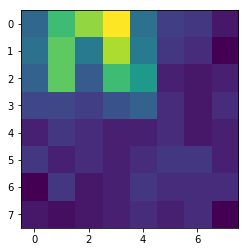

In [129]:
CUTOFF=8
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    img = img.reshape(8,8)
    #img = dct(dct(img, norm='ortho').T, norm='ortho').T
    #img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)    
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    img = img.reshape(8,8)
    #img = dct(dct(img, norm='ortho').T, norm='ortho').T
    #img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12].reshape((CUTOFF,CUTOFF)))
train_data[12], train_labels[12]

### DNN model

In [130]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(int(CUTOFF**2*0.5), activation='relu', input_shape=(CUTOFF**2,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 96)                6240      
_________________________________________________________________
dropout_32 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                3104      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 99        
Total params: 9,443
Trainable params: 9,443
Non-trainable params: 0
_________________________________________________________________


In [131]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

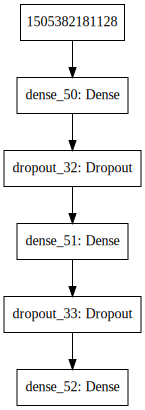

In [132]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training DNN

In [133]:
EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 1.4602 - acc: 0.2889 - val_loss: 1.2024 - val_acc: 0.3333
Epoch 2/100
90/90 [==============================] - 0s 100us/step - loss: 1.2510 - acc: 0.3778 - val_loss: 1.1298 - val_acc: 0.3111
Epoch 3/100
90/90 [==============================] - 0s 155us/step - loss: 1.2224 - acc: 0.3667 - val_loss: 1.0435 - val_acc: 0.3556
Epoch 4/100
90/90 [==============================] - 0s 111us/step - loss: 1.2604 - acc: 0.4111 - val_loss: 0.9963 - val_acc: 0.4222
Epoch 5/100
90/90 [==============================] - 0s 199us/step - loss: 1.0824 - acc: 0.4556 - val_loss: 0.9640 - val_acc: 0.4444
Epoch 6/100
90/90 [==============================] - 0s 155us/step - loss: 1.1033 - acc: 0.3778 - val_loss: 0.9355 - val_acc: 0.6222
Epoch 7/100
90/90 [==============================] - 0s 133us/step - loss: 1.0497 - acc: 0.5222 - val_loss: 0.9023 - val_acc: 0.7111
Epoch 8/100
90/90 [=======

Epoch 62/100
90/90 [==============================] - 0s 100us/step - loss: 0.3309 - acc: 0.9111 - val_loss: 0.2930 - val_acc: 0.9111
Epoch 63/100
90/90 [==============================] - 0s 100us/step - loss: 0.2729 - acc: 0.9222 - val_loss: 0.2771 - val_acc: 0.9111
Epoch 64/100
90/90 [==============================] - 0s 111us/step - loss: 0.2447 - acc: 0.9111 - val_loss: 0.2705 - val_acc: 0.9111
Epoch 65/100
90/90 [==============================] - 0s 100us/step - loss: 0.2265 - acc: 0.9556 - val_loss: 0.2613 - val_acc: 0.8889
Epoch 66/100
90/90 [==============================] - 0s 111us/step - loss: 0.2779 - acc: 0.9111 - val_loss: 0.2534 - val_acc: 0.8889
Epoch 67/100
90/90 [==============================] - 0s 89us/step - loss: 0.2479 - acc: 0.9333 - val_loss: 0.2491 - val_acc: 0.9111
Epoch 68/100
90/90 [==============================] - 0s 100us/step - loss: 0.2522 - acc: 0.9111 - val_loss: 0.2562 - val_acc: 0.9111
Epoch 69/100
90/90 [==============================] - 0s 100us/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


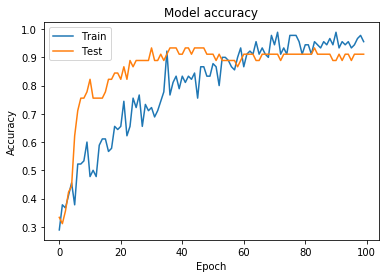

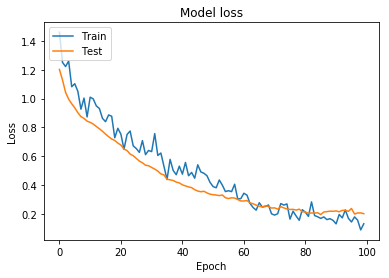

In [134]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [135]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_raw_data_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [136]:
del model
model = models.load_model(filename)

## Confirmation

In [137]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 64)

In [138]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [139]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

In [140]:
class_labels

['paper', 'rock', 'scissors']

In [141]:
(activations[-1][:10]*100).astype(int)

array([[17, 82,  0],
       [93,  6,  0],
       [99,  0,  0],
       [ 2, 97,  0],
       [ 0,  0, 99],
       [98,  1,  0],
       [96,  2,  0],
       [ 1,  5, 93],
       [ 0, 98,  0],
       [99,  0,  0]])

In [142]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])